# Gaussian Process Regression

In this notebook, we implement Gaussian Process regression described in chapter 6 of the book PRML. 

The important point is that it is essentially a Bayesian regression method, and Gaussian processes are utilized as the prior for the function to be estimated. 

In [1]:
import numpy as np
import matplotlib as mpl
from scipy.optimize import minimize
from scipy.linalg import eigh
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rc("savefig",dpi=200)

## 1 Setting 

* Let $N \in \mathbb{N}$ be the number of data points. 
* Let $d \in \mathbb{N}$ be the dimension of input data.
* Denote input data by $x_1, x_2, \dots , x_N \in \mathbb{R}^d$, and output data by $t_1, t_2, \dots, t_N \in \mathbb{R}$. Also, let $\boldsymbol{t} := {}^t (t_1, \dots, t_N) \in \mathbb{R}^N$.

## 2 Gaussian Processes

In the Gaussian process regression, we use Gaussian processes as a prior for the function to be estimated. 
In this section, we take a look at properties of Gaussian processes themselves.


### 2.1 Definition

A gaussian process is defined as a random variable over real-valued functions on a set $X$ (which will be taken to be $\mathbb{R}^d$ in this notebook), with the property that, 
for an arbitrary $N \in \mathbb{N}$ and arbitrary $x_1, x_2, \dots, x_N \in X$, 
the value of the function $y : X \rightarrow \mathbb{R}$ 
generated from the Gaussian process obeys the distribution 

$$
\begin{align}
    p\left(y(x_1), y(x_2), \dots, y(x_N)|\mu,k \right) 
    = \mathcal{N}\left((y(x_1), y(x_2), \dots, y(x_N) )^T | M, K_N \right), 
\end{align}
$$

where

$$
\begin{align}
    \mu &: X \rightarrow \mathbb{R} \\
    M &:= \left(\mu(x_1), \mu(x_2), \dots, \mu(x_N) \right)^T \ \ \in \mathbb{R}^N \\
    k &: X \times X \rightarrow \mathbb{R} \\
    K &:= \left( K_{i,j} \right)_{i,j = 1, \dots, N}, \ \ K_{i,j} = k(x_i, x_j), 
    \mbox{ with $K$ being positive definite}
\end{align}
$$

We call the function $k$ a kernel function. 

Note :
* The definition given above is by no means a mathematically rigorous, but practically sufficient, because we only care about finite input data points, i.e., finite $N$.
* I still do not know whether there always exists a Gaussian process with given $X$, $\mu$, $k$. 


### 2.2 Mean and Variance

From the definition above, if follows that

$$
\begin{align}
    & \mathbb{E}[y(x_n)] = M_n \\
    & \mathbb{E}\left[\left(y(x_n)-M_n \right) \left( y(x_m) - M_m\right) \right] = K_{n,m}
\end{align}
$$

In applications, we usually take $\mu$ to be 0, 
and hence we assume $\mu = 0$ henceforth.

### 2.3 Examples
Following the book, we consider a Gaussian process given by the kernel function 

$$
\begin{align}
    k(a,b) = \theta_0 \exp\left( -\frac{\theta_1}{2} \| a- b\|^2 \right) + \theta_2 + \theta_3 a^T b
\end{align}
$$

with non-negative hyper parameters $\theta_0, \theta_1, \theta_2, \theta_3$
(Note that at least one of $\theta_0, \theta_2, \theta_3$ has to be positive 
for the covariance matrix $K$ to be positive definite.). 

Shown below is the function that gives the covariance matrix $K_{n,m} = k(a_n, b_m)$ with $k$ being the kernel function given above.

Note about the implementation: 
* Note that the function takes matrices A and B as the input, where $A_{n,j}$ and $B_{m,j}$ stand for $j$-th element of $a_n$ and $b_m$ respectively.  
* We vectorized the implementation, and take advantage of numpy broadcasting. First, note that

$$
\begin{align}
    \| a- b\|^2 = \sum_{j=1}^{d} A_{n,j}^{2} + \sum_{j=1}^{d} B_{m,j}^{2} - 2 \sum_{j=1}^{d} A_{n,j} B_{m,j} . 
\end{align}
$$

$\sum_{j=1}^{d} A_{n,j} B_{m,j}$ can be easily calculated because 
$\sum_{j=1}^{d} A_{n,j} B_{m,j}  = (A B^T)_{n,m}$ (This also aplies to the $a_{n}^{T} b_m$ term). 

In [2]:
# inputs
# A : rank-2 array, with shape (Na, d), where a_i \in \mathbb{R}^{d} (i = 1,2, \dots, Na) OR 1D array with length Na (which corresponds to d=1)
# B : rank-2 array, with shape (Nb, d), where b_i \in \mathbb{R}^{d} (i = 1,2, \dots, Nb) OR 1D array with length Nb (which corresponds to d=1)
# thts : 1D array with four elements
# output
# K : Na \times Nb matrix, with 
#    K_{i,j} = k(a_i,b_j) = \theta_0 \exp\left( -\frac{\theta_1}{2} \| a_i- b_j \|^2 \right) + \theta_2 + \theta_3 a_{i}^{T} b_j
def genK(A,B,thts):
    # make sure that A and B are matrices
    if len(np.shape(A)) == 1:
        A = np.reshape(A, (len(A),1))
    if len(np.shape(B)) == 1:
        B = np.reshape(B, (len(B),1))

    tmp = np.reshape(np.sum(A**2,axis=1),(len(A),1)) + np.sum(B**2,axis=1)  -2*(A @ B.T)
    return thts[0]*np.exp(-thts[1]/2*tmp) + thts[2] + thts[3]*(A @ B.T)

Following the figure 6.5 of the book, we sample from the Gaussian process defined by the abov kernel function.

C:\Users\sokohaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


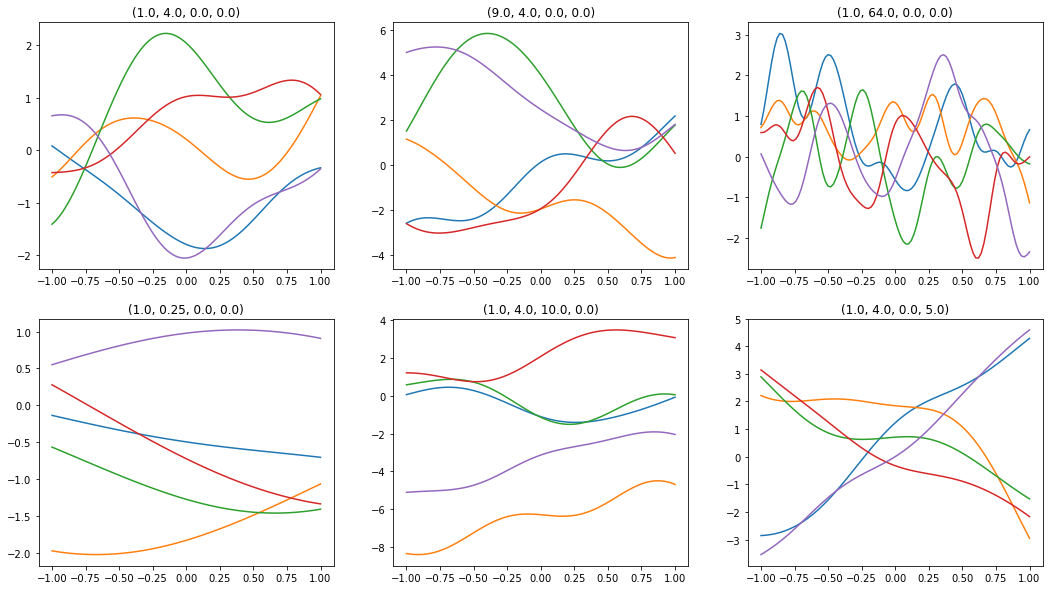

In [3]:
## 1 dimensional example
xx = np.linspace(-1,1,101)
Thts = np.array([[1.0, 4.0, 0.0, 0.0],\
                 [9.0, 4.0, 0.0, 0.0],\
                 [1.0, 64.0, 0.0,0.0],\
                 [1.0,0.25, 0.0, 0.0],\
                 [1.0, 4.0, 10.0, 0.0],\
                 [1.0, 4.0, 0.0, 5.0]\
                ])

num  = 5
cnt = 0
fig = plt.figure(figsize=(18,10))
while cnt < len(Thts):
    K = genK(xx,xx,Thts[cnt])
    yy = np.random.multivariate_normal(np.zeros(len(xx)), K, num)
    ax = fig.add_subplot(2,3,cnt+1)
    for y in yy:
        ax.plot(xx,y)
    ax.set_title("(%s, %s, %s, %s)"%(Thts[cnt][0],Thts[cnt][1],Thts[cnt][2],Thts[cnt][3]))
    cnt += 1

It can be seen that $\theta_2$ determines the scale of change(smaller $\theta_2$ means more oscillation).

"RuntimeWarning: covariance is not positive-semidefinite." probably came from numerical error (When I printed eigenvalues of $K$, some of them are of the order of $10^{-16}$.) 

## 3 GP regression

### 3.1 Likelihood

Assume that, for input data $x_n$, the output $t_n$ is given by the following model

$$
\begin{align}
    p(t_n| y(x_n)) = \mathcal{N}(t_n| y(x_n), \beta^{-1}), 
\end{align}
$$

i.e., $t_n$ is given by $y(x_n)$ plus Gaussian noise. 
By assuming the noises are independent, we have

$$
\begin{align}
    p(t| y ) = \mathcal{N}(t| y, \beta^{-1} I_N) , 
\end{align}
$$

where $y := (y(x_1), y(x_2), \dots, y(x_N))^T$ and $I_N$ is the $N$ dimensional indentity matrix. 

### 3.2 Predictive distribution

Given 

$$
\begin{align}
    \mbox{prior : } p(y) &= \mathcal{N}(y|M,K) \\
    \mbox{likelihood : } p(t|y) &=  \mathcal{N}(t| y, \beta^{-1} I_N), 
\end{align}
$$

we can calculate the predictive distribution. 

Let us make the situation clearer: we are given with $N$ data points $(x_1, t_1), (x_2, t_2), \dots, (x_N,t_N)$ and want to know the distribution over the output $t_{N+1}$ with respect to the next input $x_{N+1}$. 
By denoting 

$$
\begin{align}
    \boldsymbol{t}_{N} &:= (t_1, t_2, \dots, t_N)^T \\
    \boldsymbol{t}_{N+1} &:= (t_1, t_2, \dots, t_N, t_{N+1})^T
\end{align}
$$

we can write the probability we want as $p(t_{N+1}| \boldsymbol{t}_N)$ (Because the input data $x_1, x_2, \dots, x_{N}, x_{N+1}$ are fixed, we omit them from our formula). 

For that aim, we first calculate the joint distribution $p(\boldsymbol{t}_{N+1})$ and the compute the conditional distribution. 
$p(\boldsymbol{t}_{N+1})$ is given by (from PRML (6.61), (6.64), which can be derived from (2.115))

$$
\begin{align}
    p(\boldsymbol{t}_{N+1}) &= \mathcal{N}(\boldsymbol{t}_{N+1}| 0, C_{N+1}), \\
    C_{N+1} &:= K_{N+1} + \beta^{-1} I_{N+1}, \\
    K_{N+1} &:= \left( k(x_n,x_m) \right)_{n,m = 1, \dots, N, N+1}
\end{align}
$$

For later conveinience, we decompose $C_{N+1}$ as:

$$
\begin{align}
    C_{N+1} &= 
    \begin{pmatrix}
        C_N & \boldsymbol{k} \\
        \boldsymbol{k}^T & c
    \end{pmatrix}, \\
    c &:= k(x_{N+1},x_{N+1}) + \beta^{-1} \\
    \boldsymbol{k} &\in \mathbb{R}^{N+1}, \ \ k_n = k(x_n, x_{N+1})
\end{align}
$$

By taking the conditional distribution, we have (PRML (6.67), (6.68), which can be derived from PRML(2.81), (2.82))

$$
\begin{align}
    p(t_{N+1}|\boldsymbol{t}_N) &= \mathcal{N} (t_{N+1} | m(x_{N+1}), \sigma^2(x_{N+1})), \\
    m(x_{N+1}) &:= \boldsymbol{k}^T C_{N}^{-1} \boldsymbol{t}_N, \\
    \sigma^2(x_{N+1}) &:= c - \boldsymbol{k}^T C_{N}^{-1} \boldsymbol{k}
\end{align}
$$

Here, we give the function that calculates the mean $m(x_{N+1})$ and the standard deviation $\sigma(x_{N+1})$, as vectors for $x_{N+1} = x^{test}_{i}$

In [4]:
def pred(xtest,xtrain,ttrain,beta,thts):
    CN = genK(xtrain,xtrain,thts) + 1.0/beta*np.eye(len(xtrain))
    kmat = genK(xtrain,xtest,thts)
    cmat = genK(xtest,xtest,thts) + 1.0/beta*np.eye(len(xtest))
    mvec = (kmat.T) @ np.linalg.inv(CN) @ ttrain
    svec = np.sqrt( np.diag(  cmat -  kmat.T @ np.linalg.inv(CN)@ kmat  )  )
    return mvec,svec

## 4 Optimizing hyper parameters 

So far, we have assumed hyper parameters contained in the kernel function is fixed. 
In this section, we describe how they can be determined from the training data. 
Specifically, we choose the set of hyper parameters which maximizes the marginal likelihood $p(t|\theta)$. 

### 4.1 Marginal likelihood

As described in the previous section, we have 

$$
\begin{align}
    & p(\boldsymbol{t}|\theta) = \mathcal{N}(\boldsymbol{t} | 0, C) \\
    & C = K + \beta^{-1} I_N \\
    & K = (k(x_i,x_j))_{i,j = 1, \dots, N} \\
    & k(a,b) = \theta_0 \exp\left( -\frac{\theta_1}{2} \| a- b\|^2 \right) + \theta_2 + \theta_3 a^T b
\end{align}
$$

Thus, the log marginal likelihood is given by

$$
\begin{align}
    \log p(\boldsymbol{t}|\theta) = -\frac{1}{2} \log ({\rm det} C) 
        -\frac{1}{2} \boldsymbol{t}^T C^{-1} \boldsymbol{t} -\frac{N}{2} \log (2\pi)
\end{align}
$$

We regard it as a function of $\theta$, and maximize this function. 

### 4.2 Gradient

To perform the optimization, we also need the gradient, which is given by 

$$
\begin{align}
    \frac{\partial}{\partial \theta_i} \log p(\boldsymbol{t}|\theta) 
    = -\frac{1}{2} \mathrm{Tr} \left(C^{-1} \frac{\partial C}{\partial \theta_i} \right) + \frac{1}{2} \boldsymbol{t}^T C^{-1} \frac{\partial C}{\partial \theta_i} C^{-1} \boldsymbol{t}
\end{align}
$$

Although not written explicitly in the textbook, we also perform the optimization over $\beta$ simultaneously.
Also note that, because we want to use "scipy.optimize.minimize", the sign is inverted (See the "return" part.).

In [5]:
def CAndGradC(X,thts,beta):
    if len(np.shape(X)) == 1:
        X = np.reshape(X, (len(X),1))
    N = len(X)
    
    tmp = np.reshape(np.sum(X**2,axis=1),(len(X),1)) + np.sum(X**2,axis=1)  -2*(X @ X.T)
    
    C = thts[0]*np.exp(-thts[1]/2*tmp) + thts[2] + thts[3]*(X @ (X.T)) + 1.0/beta*np.eye(N)
    gradC0 = np.exp(-thts[1]/2*tmp)
    gradC1 = -thts[0]/2*tmp*np.exp(-thts[1]/2*tmp)
    gradC2 = np.ones((N,N))
    gradC3 = X @ (X.T)
    
    return C, np.array([gradC0, gradC1, gradC2, gradC3])

def neg_logPandGrad(hparams,xtrain,ttrain):
    thts = hparams[:4]
    beta = hparams[4]
    C,gradC = CAndGradC(xtrain,thts,beta)
    Cinv = np.linalg.inv(C)
    logDetC = np.sum(np.log(eigh(C)[0]))
    logP = -0.5*logDetC - 0.5*(ttrain @ Cinv @ttrain)
    gradLogP = np.zeros(5)
    cnt = 0
    while cnt < 4:
        gradLogP[cnt] = -0.5*np.trace(Cinv @ gradC[cnt])  + 0.5*(ttrain @ Cinv @ gradC[cnt] @Cinv @ ttrain)
        cnt += 1
    gradLogP[4] =  0.5*np.trace(Cinv)/(beta*beta)  - 0.5/(beta*beta)* (ttrain @ Cinv @ Cinv @ ttrain)
    return -logP,-gradLogP

Now, having obtained the value and the gradient of the function, we can perform the optimization as follows. 
Note that all the hyper parameters $\theta_0, \theta_1, \theta_2, \theta_3, \beta$ should be non-negative. 

In [6]:
def EmpB(xtrain,ttrain,hparams0):
    ans = minimize(neg_logPandGrad,hparams0,args=(xtrain,ttrain),jac=True,\
                   constraints=({'type':'ineq','fun':lambda x: x[0]},\
                                {'type':'ineq','fun':lambda x: x[1]},\
                                {'type':'ineq','fun':lambda x: x[2]},\
                                {'type':'ineq','fun':lambda x: x[3]},\
                                {'type':'ineq','fun':lambda x: x[4]}\
                               )\
                  )
    print(ans['message'])
    thts = ans['x'][0:4]
    beta = ans['x'][4]
    return thts,beta

## 5 Example

### 5.1 data

As an example, we use $d=1, N = 50$ data, where $x_i \in \mathbb{R}$ are drawn from uniform distribution over $[-3,3]$, and

$$
\begin{align}
    & t = f(x) + \varepsilon \\
    & f(x) = \sin(2x)  + 0.2\sin x + 0.1x \\
    & \varepsilon \sim \mathcal{N}(0, 0.09)
\end{align}
$$

The dataset is shown below:

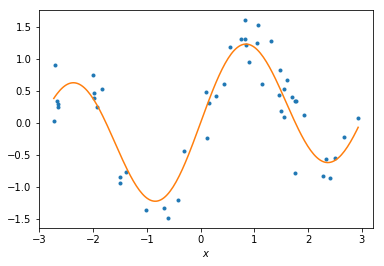

In [7]:
def truef(x):
    return np.sin(2*x)  + 0.2*np.sin(x) + 0.1*x

numdat = 50
xdat = np.random.uniform(-3,3,numdat)
ep = 0.3*np.random.randn(numdat)
ydat = truef(xdat) + ep

xcont = np.linspace(np.min(xdat),np.max(xdat),200)

plt.plot(xdat,ydat,'.')
plt.plot(xcont,truef(xcont))
plt.xlabel(r'$x$')
plt.show()

xdat = np.reshape(xdat,(len(xdat),1))

### 5.2 Gaussian Process regression (with given hyper parameters)

For sets of hyper parameters shown in section 2, Gaussian regressions are performed, 
and the results are plotted. 
The shaded region corresponds to $[m(x)-\sigma(x), m(x) + \sigma(x)]$, where $m(x)$ and $\sigma(x)$ stand for predictive mean and predictive standard deviation for $x$, respectively.

In [8]:
def plotPred(beta,thts,ax):
    xpred = np.linspace(-3,3,101)
    m,sig = pred(xpred,xdat,ydat,beta,thts)

    ax.plot(xdat,ydat,'.',label='data')
    ax.plot(xpred,m,label='predictive mean')
    ax.plot(xpred,truef(xpred),':',label='true')
    ax.fill_between(xpred,m+sig,m-sig,alpha=0.2)
    ax.legend()
    ax.set_title(r'$\beta=%s,\theta = (%s,%s,%s,%s) $'%(beta,thts[0],thts[1],thts[2],thts[3]))

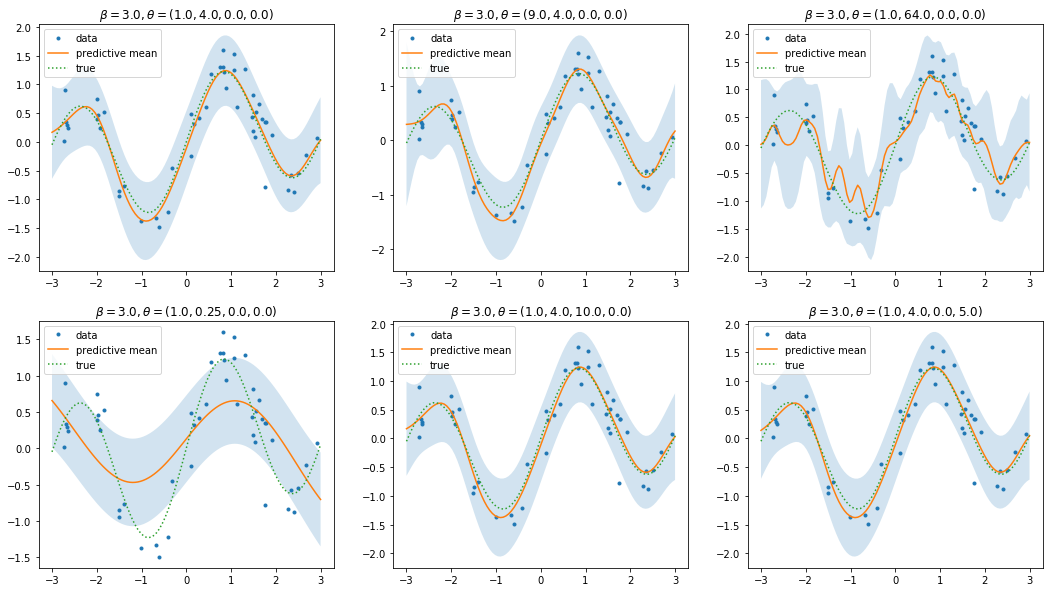

In [9]:
beta = 3.0

Thts = np.array([[1.0, 4.0, 0.0, 0.0],\
                 [9.0, 4.0, 0.0, 0.0],\
                 [1.0, 64.0, 0.0,0.0],\
                 [1.0,0.25, 0.0, 0.0],\
                 [1.0, 4.0, 10.0, 0.0],\
                 [1.0, 4.0, 0.0, 5.0]\
                ])

cnt = 0
fig = plt.figure(figsize=(18,10))
while cnt < len(Thts):
    ax = fig.add_subplot(2,3,cnt+1)
    plotPred(beta,Thts[cnt],ax)
    cnt += 1
plt.show()

We can see that the quality of the prediction crucially depends on our choice of hyper parameters.

### 5.3 Optimizing hyper parameters

Here we optimize our hyper parameters by the method described in section 4.

In [10]:
hparams0 = np.array([1.0,0.5, 0.0, 0.0,4.0])
thts,beta = EmpB(xdat,ydat,hparams0)

print(thts)
print(beta)

Optimization terminated successfully.
[  7.99227233e-01   1.80163099e+00   4.19135916e-15   2.09565238e-14]
10.4119098453


The result of the regression for the obtained hyper parameters is shown below, which looks much better than the results shown in section 5.2.

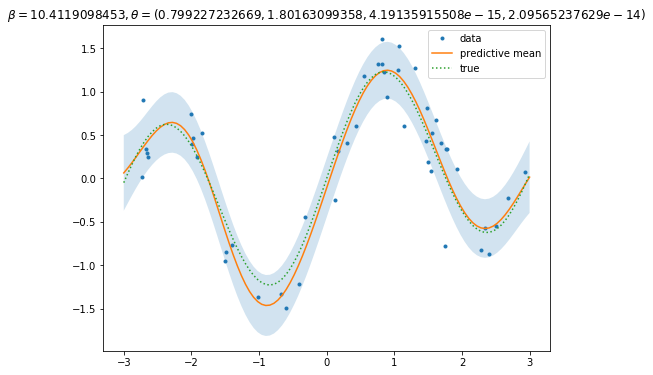

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
plotPred(beta,thts,ax)
plt.show()

## Appendix scikit-learn

In this appendix, we see how to use scikit-learn library to perform the above analysis.

* http://scikit-learn.org/stable/modules/gaussian_process.html
* http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

For simplicity, here we consider the Gaussian kernel only.

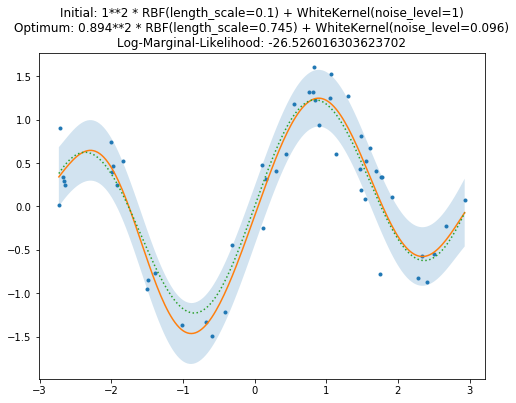

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e2)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 3e+1))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0)

# fitting 
gp.fit(xdat,ydat)

# prediction
y_mean, y_cov = gp.predict(np.reshape(xcont,(len(xcont),1)), return_cov=True)

# plotting
fig = plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.',label='data')
plt.plot(xcont, y_mean,label='predictive mean')
plt.plot(xcont, truef(xcont),':',label='true')
plt.fill_between(xcont, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.2)
plt.title(f"Initial: {kernel}\n\
Optimum: {gp.kernel_}\n\
Log-Marginal-Likelihood: {gp.log_marginal_likelihood(gp.kernel_.theta)}")
plt.show()